# BERT - Topic Modeling for Research Articles

Data <a href='https://www.kaggle.com/datasets/vin1234/janatahack-independence-day-2020-ml-hackathon?select=train.csv'>
KAGGLE Topic Modeling Dataset
</a>

<font color="brown"><b>Author:</b><br>
Akash Kumar Gautam<br>
IIT Delhi, Mathematics&Computing<br>
9+ years of Experience in Data Science + Machine Learning + Artifical Intelligence
</font>

## Introduction

<b>What is Topic Modeling?</b>

Topic modeling is a statistical technique used to uncover the underlying themes or topics present within a collection of documents. By analyzing the text of research articles—specifically the abstract and title—topic modeling algorithms can identify patterns and group articles based on shared themes. This process involves the use of natural language processing (NLP) and machine learning techniques to extract meaningful insights from unstructured text data.

#### Notebook Strategy
In this Notebook, we will utilize <font color=brown><b>BertForSequenceClassification</b></font>, a model provided by the Transformers library from HuggingFace. This model is built on the BERT architecture and features a classification head, enabling it to perform predictions at the sequence level.

This article explores the concept of <font color=blue>transfer learning</font>, which involves initially pre-training a large neural network in an unsupervised manner, followed by fine-tuning the network for a specific task. In this instance, BERT serves as the pre-trained neural network, having been trained on two tasks: masked language modeling and next sentence prediction.

Fine-tuning involves supervised learning, which indicates that a labeled dataset is required.

Note:

This Notebook presupposes that the reader possesses a fundamental understanding of several key concepts and technologies that are essential for effectively engaging with the content presented herein. Specifically, it assumes familiarity with deep learning, which is a subset of machine learning that focuses on algorithms inspired by the structure and function of the brain, particularly artificial neural networks.

Additionally, the reader should have a working knowledge of <font color=blue>BERT (Bidirectional Encoder Representations from Transformers)</font>, a state-of-the-art natural language processing model developed by Google. BERT is designed to understand the context of words in a sentence by considering the words that come before and after them, making it particularly effective for tasks such as text classification, question answering, and language inference.

Furthermore, proficiency in the <font color=blue>PyTorch</font> framework is also assumed. PyTorch is an open-source machine learning library widely used for applications in deep learning and artificial intelligence. It provides a flexible and dynamic computational graph, which allows for easy experimentation and debugging, making it a popular choice among researchers and practitioners in the field.

In summary, this article is intended for individuals who are already well-versed in these foundational topics, as it will build upon this knowledge to explore more advanced concepts and applications related to deep learning, BERT, and the use of PyTorch for implementing various models and techniques.

#### Notebook Sections
This Notebook is divided into following sections:

<b>A. Setting Environment

<b>B. Set the Device (cpu or mps)

<b>C. Reading Dataset

<b>D. Pre-Processing

<b>E. Explore Distribution of Labels

<b>F. Stratified Splitting

<b>G. Explore Distribution of Labels - Training, Validation and Testing Dataset

<b>H. Modeling (includes training Loop)

<b>I. Evaluation

<b>J. Helper Function to make Predictions

<b>K. Inference

<b>L. Saving and Loading Utilities for Model</b>

## Problem Statement
<p>
    Researchers can utilize extensive online repositories of scientific literature. However, this abundance of resources has made it increasingly challenging to locate pertinent articles. Implementing tagging or topic modeling offers a method to assign identifiers to research articles, thereby enhancing the recommendation and search processes.

Based on the abstract and title of a collection of research articles, forecast the topics for each article within the test set.

Note: It is important to recognize that a research article may encompass multiple topics. The abstracts and titles of the research articles are derived from the following six topics:

1. Computer Science
2. Physics
3. Mathematics
4. Statistics
5. Quantitative Biology
6. Quantitative Finance
</p>

## A. Setting Up the Environment and Import Libraries

In [316]:
# Uncomment to install libraries
# !pip install pandas
# !pip install numpy
# !pip install scikit-learn
# !pip install torch
# !pip install transformers
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-multilearn
# !pip install pylatexenc

# Note: For zsh shell remove exclamation (!) mark

In [2]:
import collections
from itertools import chain
import random
import copy
import itertools
import re

import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split

from pylatexenc.latex2text import LatexNodes2Text

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, random_split
from torch.optim import AdamW

from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
import seaborn as sns

# set the option to display all columns
pd.set_option('display.max_columns', None)

## B. Set Device - Check if MPS (Metal Performance Shaders) is available
PyTorch uses the new Metal Performance Shaders (MPS) backend for GPU training acceleration. This MPS backend extends the PyTorch framework, providing scripts and capabilities to set up and run operations on Mac.

In [3]:
# Function to get device
def get_device(force_cpu_device=False):
    
    # default device
    device = torch.device('cpu')
    
    # Check that MPS  is available
    if not torch.backends.mps.is_available():
        if not torch.backends.mps.is_built():
            print("MPS not available because the current PyTorch install was not "
                  "built with MPS enabled.")
        else:
            print("MPS not available because the current MacOS version is not 12.3+ "
                  "and/or you do not have an MPS-enabled device on this machine.")

    else:
        mps_device = torch.device("mps")
        device = mps_device
        print("mps device found")
        
    # Force to use the cpu device
    if force_cpu_device:
        print("force to use cpu")
        device = torch.device('cpu')
        
    return device

#### Get the device 

In [4]:
# get the device
device = get_device()

# device info
print(f"device to be used: {device}")

mps device found
device to be used: mps


## C. Reading Dataset
Load the training and testing dataset provided from the specified path into a pandas dataframe.

In [6]:
# Note: You can download the data from the Kaggle from the link below:
# train - https://www.kaggle.com/datasets/vin1234/janatahack-independence-day-2020-ml-hackathon?select=train.csv
# test - https://www.kaggle.com/datasets/vin1234/janatahack-independence-day-2020-ml-hackathon?select=test.csv

# set the filepath for KAGGLE train Dataset
train_file_path = "/Users/akg/jupyter/kaggle/article_subject_identification/data/train.csv"

# set the filepath for KAGGLE train Dataset
test_file_path = "/Users/akg/jupyter/kaggle/article_subject_identification/data/test.csv"

# read the raw train data
train_data = pd.read_csv(train_file_path, encoding='utf8')

# read the raw train data
test_data = pd.read_csv(test_file_path, encoding='utf8')

##### Peek into raw training data 

In [7]:
train_data.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


##### Peek into raw testing data

In [8]:
test_data.head()

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


## D. Preprocessing Data

### 1. Raw Statistics of the Training Data + Testing Data

In [9]:
# ---- Training Data ----------
# num of rows
train_num_rows = train_data.shape[0]
# num of cols
train_num_cols = train_data.shape[1]
# get the list of all columns
all_train_cols = list(train_data.columns)

# ---- Testing Data ----------
# num of rows
test_num_rows = test_data.shape[0]
# num of cols
test_num_cols = test_data.shape[1]
# get the list of all columns
all_test_cols = list(test_data.columns)

print("--- Training Data ---")
print(f"Total columns in raw training dataset:\t {train_num_rows}")
print(f"Total rows in raw training dataset:\t {train_num_cols}")
print(f"All training columns: {all_train_cols}")

print("\n---Testing Data--")
print(f"Total columns in raw testing dataset:\t {test_num_rows}")
print(f"Total rows in raw testing dataset:\t {test_num_cols}")
print(f"All testing columns: {all_test_cols}")

--- Training Data ---
Total columns in raw training dataset:	 20972
Total rows in raw training dataset:	 9
All training columns: ['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']

---Testing Data--
Total columns in raw testing dataset:	 8989
Total rows in raw testing dataset:	 3
All testing columns: ['ID', 'TITLE', 'ABSTRACT']


### 2. Analyze the <font color=blue>raw training dataset</font> to perform some basic necessary checks to validate the data 

#### 2.1 Check for duplicate IDs
<p>
    Check if the <b>ID</b> column have <font color=brown><b>unique</b></font> values in raw training dataset. We are doing this step just to make sure and double
    check that ID do not have any duplicate values.
</p>

In [10]:
# check if ID have duplication in Training data
train_id_check_ = train_data['ID'].duplicated().any()
print(f"Does IDs in training data have duplicate values? {train_id_check_}")

Does IDs in training data have duplicate values? False


### 3. Set the target Columns
<p> <b>Set</b> the <font color=brown><b>Target</b></font> variable from the raw training data</p>

In [11]:
targets = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']

### 4. Convert Latex encodd text into plain text + replace newline character by a space ' '
<p>
    Generally, Research paper includes latex encoded text to create equations. So we need to decode to this
    encoded latex into plain text. For example <b>\$\\\theta$</b> should get resolve into <b>θ</b>. Also, it can be see that there is a newline character '\n'
    present inside the text. So we need to remove this by a space ' '.
</p>

#### 4.1. Lets peek into a random text

In [12]:
train_data.iloc[3]['ABSTRACT']

'  The stochastic Landau--Lifshitz--Gilbert (LLG) equation coupled with the\nMaxwell equations (the so called stochastic MLLG system) describes the creation\nof domain walls and vortices (fundamental objects for the novel nanostructured\nmagnetic memories). We first reformulate the stochastic LLG equation into an\nequation with time-differentiable solutions. We then propose a convergent\n$\\theta$-linear scheme to approximate the solutions of the reformulated system.\nAs a consequence, we prove convergence of the approximate solutions, with no or\nminor conditions on time and space steps (depending on the value of $\\theta$).\nHence, we prove the existence of weak martingale solutions of the stochastic\nMLLG system. Numerical results are presented to show applicability of the\nmethod.\n'

#### 4.2. Convert latext text to plain text 

In [13]:
train_data['TITLE'] = train_data['TITLE'].apply(lambda x: LatexNodes2Text().latex_to_text(x.replace('\n', ' ')))
train_data['ABSTRACT'] = train_data['ABSTRACT'].apply(lambda x: LatexNodes2Text().latex_to_text(x.replace('\n', ' ')))

### 5. Set the feature 'text' column
<p>In our research paper, we incorporate both a title and an abstract, each presented in a textual format. The title serves as a concise representation of the main topic or focus of the research, while the abstract provides a brief summary of the key objectives, methodologies, findings, and implications of the study. To enhance our analysis and improve the effectiveness of our feature extraction process, we will merge these two elements into a single, cohesive set of textual data. This unified dataset will allow us to leverage the combined information from both the title and the abstract, facilitating a more comprehensive understanding of the research content. By treating the merged text as a singular feature, we aim to capture the essence of the research more effectively, which can be beneficial for various applications such as text classification, information retrieval, and machine learning models. This approach not only streamlines our data processing but also enriches the contextual information available for further analysis.</p>

In [14]:
# create a 'text' column by combining the textual information from title + abstract data
train_data['text'] = train_data['TITLE'] + train_data['ABSTRACT']

#### 5.1. Peek into the text column 

In [15]:
train_data['text'][3]

'A finite element approximation for the stochastic Maxwell–Landau–Lifshitz–Gilbert system  The stochastic Landau–Lifshitz–Gilbert (LLG) equation coupled with the Maxwell equations (the so called stochastic MLLG system) describes the creation of domain walls and vortices (fundamental objects for the novel nanostructured magnetic memories). We first reformulate the stochastic LLG equation into an equation with time-differentiable solutions. We then propose a convergent θ-linear scheme to approximate the solutions of the reformulated system. As a consequence, we prove convergence of the approximate solutions, with no or minor conditions on time and space steps (depending on the value of θ). Hence, we prove the existence of weak martingale solutions of the stochastic MLLG system. Numerical results are presented to show applicability of the method. '

<b>Observation</b>
<p>
    Now it can be seen that latex encode text are converted into plain readable text. Also there is no newline character present inside the text.
</p>

### 6. Further preprocess the text using the following function to make the text cleaner

In [16]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    Inputs
    -------
    text (str): a string to be processed and clean

    Returns
    --------
    text (Str): the processed clean string.
    """
    
    text = text.lower()
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r" \ ", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'//', ' ', text)
    
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Substitue '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

#### 6.1. Apply the preprocessing function 

In [17]:
train_data['text'] = train_data['text'].apply(text_preprocessing)

#### 6.2. Peek into a random row 

In [18]:
train_data.iloc[6220].values

array([6221, '99',
       '  It is well known that many optimization methods, including SGD, SAGA, and Accelerated SGD for over-parameterized models, do not scale linearly in the parallel setting. In this paper, we present a new version of block coordinate descent that solves this issue for a number of methods. The core idea is to make the sampling of coordinate blocks on each parallel unit independent of the others. Surprisingly, we prove that the optimal number of blocks to be updated by each of n units in every iteration is equal to m/n, where m is the total number of blocks. As an illustration, this means that when n=100 parallel units are used, 99% of work is a waste of time. We demonstrate that with m/n blocks used by each unit the iteration complexity often remains the same. Among other applications which we mention, this fact can be exploited in the setting of distributed optimization to break the communication bottleneck. Our claims are justified by numerical experiments which

### 7. Drop the unwanted columns
<p>Let us now drop the columns 'TITLE' and 'ABSTRACT' as they are no longer needed</p>

In [19]:
train_data.drop(columns=['TITLE', 'ABSTRACT'], inplace=True)

# rearrange the columns
train_data = train_data[['text'] + targets]

#### 7.1. Verify if the columns are indeed dropped 

In [20]:
train_data.head()

,text,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,reconstructing subject-specific effect maps pr...,1,0,0,0,0,0
1,rotation invariance neural network rotation in...,1,0,0,0,0,0
2,spherical polyharmonics and poisson kernels fo...,0,0,1,0,0,0
3,a finite element approximation for the stochas...,0,0,1,0,0,0
4,comparative study of discrete wavelet transfor...,1,0,0,1,0,0


### 8. Create additional columns to get an idea of sentence length, bert tokens length 

In [21]:
# set the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

#### 8.1. Create column to store sentence length

In [22]:
train_data['num_words'] = train_data['text'].apply(lambda x: len(x.split(' ')))

#### 8.2. Create column to store num of tokens (after tokenizing text) 

In [23]:
train_data['num_tokens'] = train_data['text'].apply(lambda x: len(tokenizer.tokenize(x)))

#### 8.3. Create a column to store the difference between number of words and number of tokens 

In [24]:
train_data['tokens_words_diff'] = train_data['num_tokens'] - train_data['num_words']

#### 8.4. Check if num of tokens > num of words 

In [25]:
train_data[train_data['tokens_words_diff'] < 0]

,text,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,num_words,num_tokens,tokens_words_diff


#### 8.5. Peek at a random row 

In [26]:
train_data.iloc[67].values

array(['s^1-equivariant index theorems and morse inequalities on complex manifolds with boundary let m be a complex manifold of dimension n with smooth connected boundary x. assume that m admits a holomorphic s^1-action preserving the boundary x and the s^1-action is transversal and cr on x. we show that the ∂-neumann laplacian on m is transversally elliptic and as a consequence, the m-th fourier component of the q-th dolbeault cohomology group h^q_m(m) is finite dimensional, for every m∈ℤ and every q=0,1,…,n. this enables us to define ∑^n_j=0(-1)^j dim h^q_m(m) the m-th fourier component of the euler characteristic on m and to study large m-behavior of h^q_m(m). in this paper, we establish an index formula for ∑^n_j=0(-1)^j dim h^q_m(m) and morse inequalities for h^q_m(m).',
       0, 0, 1, 0, 0, 0, 122, 246, 124], dtype=object)

### 9. Lets see the distributions of number of words, number of tokens and their difference 

#### 9.1. Histogram of number of words (a.k.a sentence length)

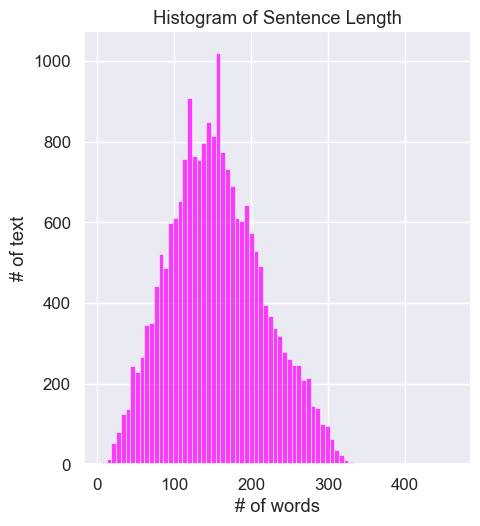


Stats for length of Tokens
Minimum sentence length: 6
Maximum sentence length: 462
Median sentence length: 151


In [27]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.1)
sentence_length = train_data['num_words'].values.tolist()

min_sentence_length = min(sentence_length)
max_sentence_length = max(sentence_length)
median_sentence_length = int(np.median(sentence_length))

# Plot the distribution of comment lengths.
g = sns.displot(sentence_length, kde=False, rug=False,color='magenta')

plt.title('Histogram of Sentence Length')
plt.xlabel('# of words')
plt.ylabel('# of text')
plt.show()

print("\nStats for length of Tokens")
print(f"Minimum sentence length: {min_sentence_length}") 
print(f"Maximum sentence length: {max_sentence_length}") 
print(f"Median sentence length: {median_sentence_length}")

#### 9.3. Check the training data where number of words are less than 10

In [28]:
train_data[train_data['num_words']<10]['text'].values.tolist()

["are theoretical results are sults'? yes.",
 'city-scale intelligent systems and platforms as of 2014, 54']

#### 9.4. Histogram of length of tokenized sentence (# of tokens created by tokenizer)

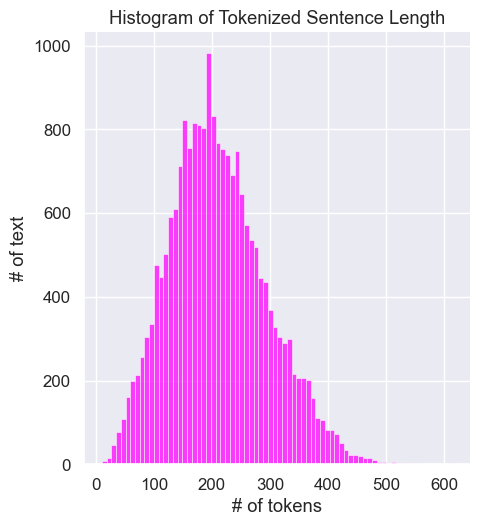


Stats for length of Tokens
Minimum tokenized sentence length: 10
Maximum tokenized sentence length: 615
Median tokenized sentence length: 203


In [29]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.1)
tokenized_sentence_length = train_data['num_tokens'].values.tolist()

min_tokenized_sentence_length = min(tokenized_sentence_length)
max_tokenized_sentence_length = max(tokenized_sentence_length)
median_tokenized_sentence_length = int(np.median(tokenized_sentence_length))

# Plot the distribution of comment lengths.
g = sns.displot(tokenized_sentence_length, kde=False, rug=False,color='magenta')

plt.title('Histogram of Tokenized Sentence Length')
plt.xlabel('# of tokens')
plt.ylabel('# of text')
plt.show()

print("\nStats for length of Tokens")
print(f"Minimum tokenized sentence length: {min_tokenized_sentence_length}") 
print(f"Maximum tokenized sentence length: {max_tokenized_sentence_length}") 
print(f"Median tokenized sentence length: {median_tokenized_sentence_length}")

#### 9.5. Histogram of difference in length between sentence length and bert tokenized sentence length

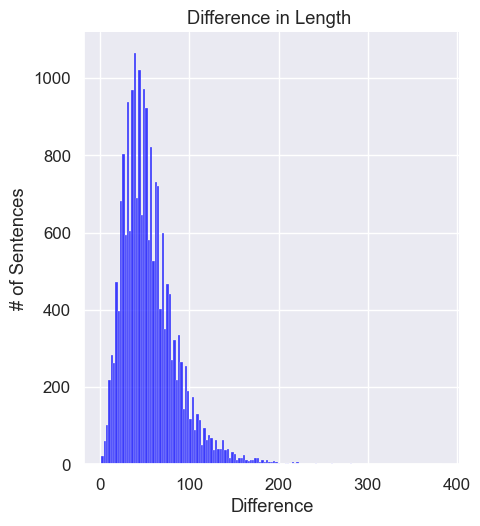


Stats for length difference between Bert Tokens and sentence length
Minimum difference in num of tokens and num of words: 1
Maximum difference in num of tokens and num of words: 384
Median difference in num of tokens and num of words: 50


In [30]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.1)

tokens_words_diff = train_data['tokens_words_diff'].values.tolist()

min_tokens_words_diff = min(tokens_words_diff)
max_tokens_words_diff = max(tokens_words_diff)
median_tokens_words_diff = int(np.median(tokens_words_diff))

# Plot the distribution of comment lengths.
sns.displot(tokens_words_diff, kde=False, rug=False,color='blue')

plt.title('Difference in Length ')
plt.xlabel('Difference')
plt.ylabel('# of Sentences')
plt.show()

print("\nStats for length difference between Bert Tokens and sentence length")
print(f"Minimum difference in num of tokens and num of words: {min_tokens_words_diff}") 
print(f"Maximum difference in num of tokens and num of words: {max_tokens_words_diff}") 
print(f"Median difference in num of tokens and num of words: {median_tokens_words_diff}")

### 10. Drop the newly created columns for lengths 

In [31]:
# Droping the new columns by retaining the necessary columns
train_data = train_data[['text'] + targets]

In [32]:
train_data.head()

,text,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,reconstructing subject-specific effect maps pr...,1,0,0,0,0,0
1,rotation invariance neural network rotation in...,1,0,0,0,0,0
2,spherical polyharmonics and poisson kernels fo...,0,0,1,0,0,0
3,a finite element approximation for the stochas...,0,0,1,0,0,0
4,comparative study of discrete wavelet transfor...,1,0,0,1,0,0


### 11. Compute label Maps
Create two maps:

1. <b>label2id</b> - maps string labels to its integer index
2. <b>id2label</b> - maps integer index of labels to strings

In [33]:
label2id = {k: v for v, k in enumerate(targets)}
id2label = {v: k for v, k in enumerate(targets)}
label2id

{'Computer Science': 0,
 'Physics': 1,
 'Mathematics': 2,
 'Statistics': 3,
 'Quantitative Biology': 4,
 'Quantitative Finance': 5}

## E. Explore distributions of Labels 

### 1. Create a new dataframe to explore distributions of labels 

In [34]:
bal_df = train_data[targets].copy()

### 2. Descriptive Statistics of each label 

In [35]:
bal_df.describe()

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
count,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000
mean,0.409784,0.286716,0.267881,0.248236,0.027990,0.011873
std,0.491806,0.452238,0.442866,0.432000,0.164947,0.108317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 3. Frequency of each label 

In [36]:
# count the frequency of each label in ascending order
labels_counts = bal_df.sum(axis=0).sort_values(ascending=False)

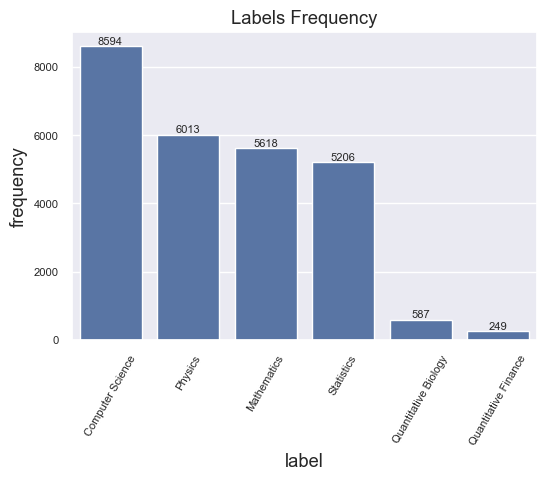

In [37]:
# plot the bar plot for frequencies
fig, ax = plt.subplots(figsize=(6, 4))
ax.yaxis.set_tick_params(labelsize = 8)
ax.xaxis.set_tick_params(labelsize = 8)
plt.xticks(rotation=60)
g = sns.barplot(x=labels_counts.index, y=labels_counts.values, ax=ax)
ax.set(xlabel='label', ylabel='frequency', title='Labels Frequency')
ax.bar_label(ax.containers[0], fontsize=8)
plt.show()

## F. Stratified (or Balanced) Split

### 1. Helper Functions to Create Balanced Split function 

In [38]:
# create multilabel binarizer
mlb = MultiLabelBinarizer(classes=list(label2id.keys()))

# Function to create stratified split
def balanced_split(df, mlb, test_size):
    ind_ = np.expand_dims(np.arange(len(df)), axis=1)
    # series of unique labels
    unique_labels_ = df[targets].apply(lambda x: tuple(x[x == 1].index), axis=1)
    labels_ohe_ = mlb.fit_transform(unique_labels_)
    ind_train, _, ind_test, _ = iterative_train_test_split(
        ind_, labels_ohe_, test_size
    )
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:, 0]]

### 2. Spliting the train data into training + validation data

#### 2. a) All Data - Train Data(90%) + Validation Data (10%)

In [39]:
train_df, valid_df = balanced_split(train_data, mlb, test_size=0.1)

##### Check the size of each data 

In [40]:
print(f"Full training data size: {len(train_data)}")
print(f"Train Dataset size: {len(train_df)}")
print(f"Valid Data Size: {len(valid_df)}")

Full training data size: 20972
Train Dataset size: 18876
Valid Data Size: 2096


##### reset the indices

In [41]:
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

## G. Explore Distribution of Labels - Training, Validation   

In [42]:
# one hot encoding of unique labels for trainig data
unique_train_labels_ohe = mlb.transform(train_df[targets].apply(lambda x: tuple(x[x == 1].index), axis=1))

# one hot encoding of unique labels for validation data
unique_valid_labels_ohe = mlb.transform(valid_df[targets].apply(lambda x: tuple(x[x == 1].index), axis=1))

### 1. Check distributions of 1st order 

In [43]:
# compute number of samples
num_train_samples = unique_train_labels_ohe.shape[0]
num_valid_samples = unique_valid_labels_ohe.shape[0]

# compute number of samples for each unique label
train_labels_count = unique_train_labels_ohe.sum(axis=0)
valid_labels_count = unique_valid_labels_ohe.sum(axis=0)

# compute proportion of samples for each unique label
prop_train_labels = train_labels_count/num_train_samples
prop_valid_labels = valid_labels_count/num_valid_samples


print("Training Data")
print("==============")
print(f"Total num of training samples: {num_train_samples}")
print(f"Total num of each label: {train_labels_count}")
print(f"Proportions of each label: {prop_train_labels}\n")

print("Validation Data")
print("==============")
print(f"Total num of validation samples: {num_valid_samples}")
print(f"Total num of each label: {valid_labels_count}")
print(f"Proportions of each label: {prop_valid_labels}\n")

Training Data
Total num of training samples: 18876
Total num of each label: [7735 5412 5056 4685  528  224]
Proportions of each label: [0.40977961 0.28671329 0.26785336 0.24819877 0.02797203 0.01186692]

Validation Data
Total num of validation samples: 2096
Total num of each label: [859 601 562 521  59  25]
Proportions of each label: [0.40982824 0.28673664 0.26812977 0.2485687  0.02814885 0.01192748]



#### 1a. Create the proportion dataFrame for training, validation and testing data

In [44]:
# create dict for proportions of each label
prop_data = {
    'labels' : list(label2id.keys()),
    'train' : prop_train_labels,
    'valid' : prop_valid_labels,
}

# create dataframe
prop_df = pd.DataFrame.from_dict(prop_data)

# display
display(prop_df)

,labels,train,valid
0,Computer Science,0.409780,0.409828
1,Physics,0.286713,0.286737
2,Mathematics,0.267853,0.268130
3,Statistics,0.248199,0.248569
4,Quantitative Biology,0.027972,0.028149
5,Quantitative Finance,0.011867,0.011927


#### 1b. Plot distribution of proportions across each label for training, validation and testing data

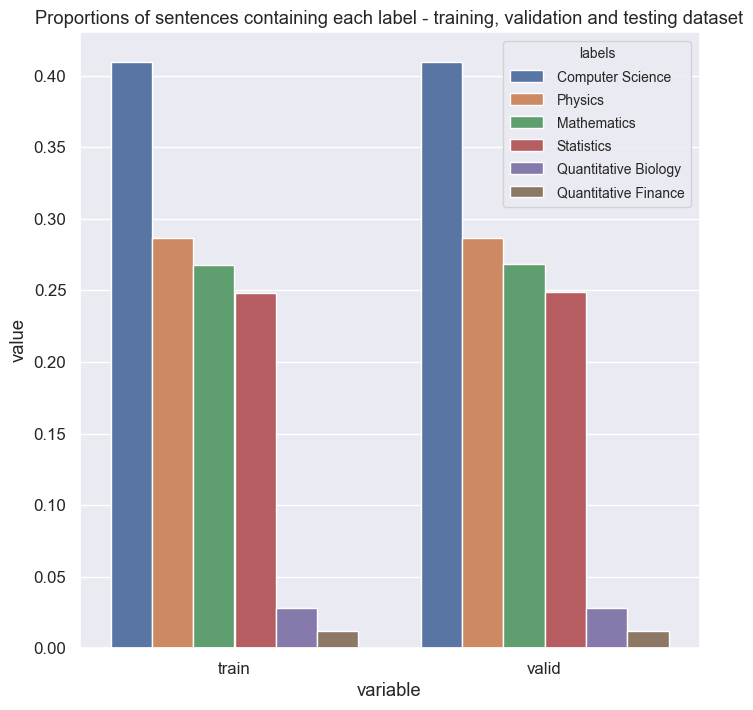

In [45]:
fig, ax = plt.subplots(figsize=(8, 8))
g = sns.barplot(
    data=prop_df.melt(id_vars = ["labels"], value_vars=["train", "valid"]),
    y="value", x="variable", hue="labels", errorbar=None
)

# for legend text
plt.setp(g.get_legend().get_texts(), fontsize='10')  
 
# for legend title
plt.setp(g.get_legend().get_title(), fontsize='10')
plt.title("Proportions of sentences containing each label - training, validation and testing dataset")

plt.show()

#### 2. Check distributions of 2nd order

In [46]:
from collections import Counter
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

label_combination_df = pd.DataFrame({
    'train': Counter(str(combination) for row in get_combination_wise_output_matrix(unique_train_labels_ohe, order=2) for combination in row),
    'valid': Counter(str(combination) for row in get_combination_wise_output_matrix(unique_valid_labels_ohe, order=2) for combination in row),
}).T.fillna(0.0).astype('float')

# compute proportions
label_combination_df.loc['train'] = label_combination_df.loc['train']/num_train_samples
label_combination_df.loc['valid'] = label_combination_df.loc['valid']/num_valid_samples

label_combination_df

,"(0, 0)","(2, 2)","(1, 1)","(4, 4)","(1, 2)","(2, 3)","(3, 3)","(0, 3)","(0, 2)","(0, 1)","(1, 3)","(0, 4)","(5, 5)","(3, 4)","(3, 5)","(0, 5)","(4, 5)","(2, 5)"
train,0.409780,0.267853,0.286713,0.027972,0.015310,0.048368,0.248199,0.119517,0.041958,0.023469,0.006887,0.001695,0.011867,0.005245,0.001271,0.000530,0.000212,0.000053
valid,0.409828,0.268130,0.286737,0.028149,0.015267,0.048187,0.248569,0.119752,0.041985,0.023378,0.006679,0.001431,0.011927,0.005248,0.001431,0.000477,0.000000,0.000000


#### 3. Check distribution of 3rd order

In [47]:
from collections import Counter
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

label_combination_df = pd.DataFrame({
    'train': Counter(str(combination) for row in get_combination_wise_output_matrix(unique_train_labels_ohe, order=3) for combination in row),
    'valid': Counter(str(combination) for row in get_combination_wise_output_matrix(unique_valid_labels_ohe, order=3) for combination in row),
}).T.fillna(0.0).astype('float')

# compute proportions
label_combination_df.loc['train'] = label_combination_df.loc['train']/num_train_samples
label_combination_df.loc['valid'] = label_combination_df.loc['valid']/num_valid_samples

label_combination_df

,"(0, 0, 0)","(2, 2, 2)","(1, 1, 1)","(4, 4, 4)","(1, 2, 2)","(1, 1, 2)","(2, 2, 3)","(2, 3, 3)","(3, 3, 3)","(0, 3, 3)","(0, 0, 3)","(0, 2, 2)","(0, 0, 2)","(0, 0, 1)","(0, 1, 1)","(0, 2, 3)","(1, 1, 3)","(1, 3, 3)","(0, 0, 4)","(0, 4, 4)","(5, 5, 5)","(3, 4, 4)","(3, 3, 4)","(3, 3, 5)","(3, 5, 5)","(0, 1, 3)","(0, 5, 5)","(0, 0, 5)","(4, 4, 5)","(4, 5, 5)","(0, 3, 4)","(0, 1, 2)","(1, 2, 3)","(0, 3, 5)","(2, 5, 5)","(2, 2, 5)","(2, 3, 5)"
train,0.409780,0.267853,0.286713,0.027972,0.015310,0.015310,0.048368,0.048368,0.248199,0.119517,0.119517,0.041958,0.041958,0.023469,0.023469,0.008635,0.006887,0.006887,0.001695,0.001695,0.011867,0.005245,0.005245,0.001271,0.001271,0.001695,0.000530,0.000530,0.000212,0.000212,0.000265,0.000954,0.000424,0.000106,0.000053,0.000053,0.000053
valid,0.409828,0.268130,0.286737,0.028149,0.015267,0.015267,0.048187,0.048187,0.248569,0.119752,0.119752,0.041985,0.041985,0.023378,0.023378,0.007634,0.006679,0.006679,0.001431,0.001431,0.011927,0.005248,0.005248,0.001431,0.001431,0.001908,0.000477,0.000477,0.000000,0.000000,0.000000,0.000477,0.000477,0.000000,0.000000,0.000000,0.000000


## H. Modelling

### 1. Modelling Parameters

In [289]:
# Max sequence length
# Note: Since we are dealing with longer texts hence MAX_LEN is large
MAX_LEN = 512

# Batch Size
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 4

# Training Epochs
EPOCHS = 10

# Optimizer params
LEARNING_RATE = 1e-06
ADAMS_EPSILON = 1e-7

# clipping grad norms
MAX_GRAD_NORM = 1.0

# tokenizer to use
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

### 2. Preparing the dataset and dataloader

#### 2.1. Create Custom Topic Dataset class 

In [290]:
class TopicDataset(Dataset):
    """Custom Topic Dataset to get input ids, attn_masks and labels.
    Inputs:
    - df: dataframe with columns ['text','Computer Science', 'Physics', 'Mathematics',
    'Statistics', 'Quantitative Biology','Quantitative Finance' ]
    """
    def __init__(self, df, tokenizer, max_len=512, topics=targets):
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input df should be a dataframe.")
        for topic in topics:
            if topic not in df.columns:
                raise ValueError(f"DataFrame should contain {topic} column.")
        if 'text' not in df.columns:
            raise ValueError(f"Dataframe should contain 'text' column")

        self.data = df
        self.len = len(df)
        self.tokenizer = tokenizer
        self.topics = topics
        self.max_len = max_len

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        # get text at index idx
        text = self.data['text'][idx]
        
        # get the corresponding labels
        labels = self.data[self.topics].values[idx]
        
        # compute input ids and attenton masks
        encoded_text_dict = tokenizer.encode_plus(text, # text to encode
                                                  add_special_tokens=True, # Add [CLS] and [SEP] tokens
                                                  truncation=True, 
                                                  max_length=self.max_len,
                                                  padding='max_length',
                                                  return_attention_mask=True, # construct atn masks
                                                  return_tensors='pt' # pytorch tensors
                                                 )
        
        input_ids = encoded_text_dict['input_ids'][0]
        attn_masks = encoded_text_dict['attention_mask'][0]
        
        items = {
            'input_ids': input_ids,
            'attn_masks': attn_masks,
            'labels': torch.tensor(labels, dtype=torch.float32)
        }
        
        return items

#### 2.3. Create Train Dataset, Valid Dataset

In [291]:
# create train dataset
train_dataset = TopicDataset(train_df, tokenizer, MAX_LEN, topics=targets)
# create validation dataset
valid_dataset = TopicDataset(valid_df, tokenizer, MAX_LEN, topics=targets)
# create test dataset

#### 2.4. Create Train DataLoader and Valid DataLoader

In [292]:
# set the batch size for train, valid and test dataloader
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True
               }

valid_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False
               }

# create the train dataloader
train_dataloader = DataLoader(train_dataset, **train_params)
# create the validation dataloader
valid_dataloader = DataLoader(valid_dataset, **valid_params)

### 3. Create Model
We present a novel language representation model known as BERT, which stands for Bidirectional Encoder Representations from Transformers. In contrast to other recent models, BERT is specifically engineered to pre-train deep bidirectional representations from unlabeled text by simultaneously considering both left and right contexts across all layers. Consequently, the pre-trained BERT model can be easily fine-tuned by adding a single output layer, enabling the development of cutting-edge models for various tasks, including question answering and language inference, without the need for significant alterations to the task-specific architecture.

In [295]:
# create BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = 6,
                                                      label2id = label2id,
                                                      id2label = id2label,
                                                      problem_type = "multi_label_classification")
# move the model to device
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

#### 4. Set the Optimizer
Optimizer - AdamW:

AdamW is a stochastic optimization method that modifies the typical implementation of weight decay in Adam, by decoupling weight decay from the gradient update.

Learning Rate:

Learning rate is a tuning parameter in machine learning and statistics that controls how much a model's parameters adjust during each iteration of an optimization algorithm. It's a floating point number that's usually between 0.01 and 0.1

Adam Epsilon:

The parameter epsilon shows up in the update step.

θ_t <- θ_{t-1} - α • mhat_t / (sqrt(vhat_t) + ε)

It is primarily used as a guard against a zero second second moment causing a division by zero case. If it is too large it will bias the moment estimation.

In [296]:
# set the learning rate
learning_rate = LEARNING_RATE

# set the adam's epsilon
# The term added to the denominator to improve numerical stability
adam_epsilon = ADAMS_EPSILON

# Load the AdamW optimizer
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, # args.learning_rate 
                  eps = adam_epsilon # args.adam_epsilon 
                )

print(f"learning rate: {learning_rate}")
print(f"adams epsilon: {adam_epsilon}")

learning rate: 1e-06
adams epsilon: 1e-07


#### 5. Set the Scheduler
A scheduler is to make learning rate adaptive to the gradient descent optimization procedure, so you can increase performance and reduce training time.

In PyTorch, a model is updated by an optimizer and learning rate is a parameter of the optimizer.

Learning rate schedule is an algorithm to update the learning rate in an optimizer.

In [297]:
# Number of training epochs 
epochs = EPOCHS

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

print(f"total steps: {total_steps}")

# create the learning scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

total steps: 11800


#### 6. Create the training loop
A typical training loop in PyTorch iterates over the batches for a given number of epochs.

In each batch iteration, we first compute the forward pass to obtain the neural network outputs.
Then, we reset the gradient from the previous iteration and perform backpropagation to obtain the gradient of the loss with respect to the model weights.
Finally, we update the weights based on the loss gradients using stochastic gradient descent.
Since we are using learning scheduler for the adaptive learning rate, we call scheduler.step() to update the learning rate (as per the learning scheduler) after every epoch.

In [298]:
def train_loop(model, train_dataloader, optimizer, epochs, device=torch.device('cpu'), seed_val=42):
    
    # set the random seeds
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)

    # initially set best model to model
    # This model corresponds to the min loss model
    best_model = model
    # min loss function (initially set to a large value)
    min_train_loss = 10000000
    
    # store loss values for each epoch
    loss_values = []

    for epoch_i in range(0, epochs):
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')
        # training loss
        total_loss = 0
    
        # train mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            if step%40 == 0 and not step == 0:
                # report progress of the training
                print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
                # batch input ids
                batch_input_ids = batch['input_ids'].to(device)
                # batch input mask
                batch_input_mask = batch['attn_masks'].to(device)
                # batch labels
                batch_labels = batch['labels'].to(device)

                # Zero the gradients to start fresh next time
                model.zero_grad()

                # get the output
                outputs = model(batch_input_ids, token_type_ids=None,
                                attention_mask=batch_input_mask, labels=batch_labels)
                loss = outputs[0]
                
                # add the loss
                total_loss += loss.item()
            
                # gradient computing step
                # -----------------------
                # loss.backward() computes dloss/dx for every parameter x which
                # has requires_grad=True. These are accumulated into x.grad
                # for every parameter x.
                loss.backward()

                # clips the norm of the overall gradient by concatenating all
                # parameters passed to the function
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
                # Tell the optimizer the gradients, then step.
                # Performs a single optimization step (parameter update)
            optimizer.step()

            # We need this step to dynamically change learning rate
            # else it won’t be changed.
            # To introduce a learning rate scheduler,
            # you need to run its step() function in the training loop.
            scheduler.step()
            
        # Compute the average training loss per instance
        avg_train_loss = total_loss / len(train_dataloader)
        loss_values.append(avg_train_loss)
        print("  Average training loss: {0:.4f}".format(avg_train_loss))

        # track the min loss and update the best model accordingly
        if avg_train_loss < min_train_loss:
            print("updating the model")
            min_train_loss = avg_train_loss
            # update the model
            best_model = copy.deepcopy(model)
        print("Minimum Average training loss: {0:.4f}".format(avg_train_loss))

    return loss_values, min_train_loss, best_model

### 7. Training Phase

In [299]:
avg_train_loss, min_avg_train_loss, best_model = train_loop(model, train_dataloader, optimizer,  epochs, device=device, seed_val=42)

======== Epoch 1 / 10 ========
Training...
  Batch    40  of  1,180.
  Batch    80  of  1,180.
  Batch   120  of  1,180.
  Batch   160  of  1,180.
  Batch   200  of  1,180.
  Batch   240  of  1,180.
  Batch   280  of  1,180.
  Batch   320  of  1,180.
  Batch   360  of  1,180.
  Batch   400  of  1,180.
  Batch   440  of  1,180.
  Batch   480  of  1,180.
  Batch   520  of  1,180.
  Batch   560  of  1,180.
  Batch   600  of  1,180.
  Batch   640  of  1,180.
  Batch   680  of  1,180.
  Batch   720  of  1,180.
  Batch   760  of  1,180.
  Batch   800  of  1,180.
  Batch   840  of  1,180.
  Batch   880  of  1,180.
  Batch   920  of  1,180.
  Batch   960  of  1,180.
  Batch 1,000  of  1,180.
  Batch 1,040  of  1,180.
  Batch 1,080  of  1,180.
  Batch 1,120  of  1,180.
  Batch 1,160  of  1,180.
  Average training loss: 0.0114
updating the model
Minimum Average training loss: 0.0114
======== Epoch 2 / 10 ========
Training...
  Batch    40  of  1,180.
  Batch    80  of  1,180.
  Batch   120  of  

### 8. Draw the graph for training loss to see its progress after every epoch

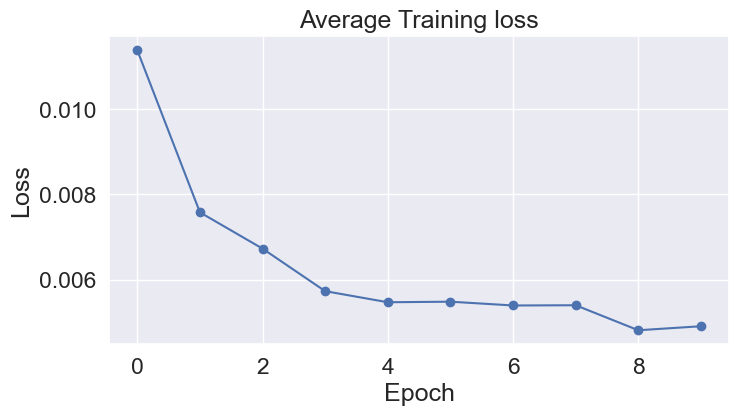

In [300]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 4))
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)

# Plot the learning curve.
plt.plot(avg_train_loss, 'b-o')

# Label the plot.
plt.title("Average Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## I. Evaluation

### 1. Create the Evaluation Function

In [301]:
def eval_fn(model, test_dataloader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_labels, eval_pred_labels, eval_pred_probs = [], [], []

    with torch.no_grad():
        for idx, batch in enumerate(test_dataloader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attn_masks'].to(device, dtype = torch.long)
            targets = batch['labels'].to(device, dtype = torch.float32)
            
            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
            loss, eval_logits = outputs.loss, outputs.logits
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += targets.size(0)
        
            if idx % 40==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 40 evaluation steps: {loss_step}")

            # compute predicted probabilities
            pred_probs = eval_logits.sigmoid()#.cpu().numpy()

            # compute predicted labels
            pred_labels = (pred_probs > 0.5).int()

            # actual true labels
            true_labels = targets.cpu().numpy()

            # actual predicted labels
            predicted_labels = pred_labels.cpu().numpy()

            # actual predicted probabilities
            predicted_probabilites = pred_probs.cpu().numpy()

            eval_labels.extend(true_labels.astype(np.int32).tolist())
            eval_pred_labels.extend(predicted_labels.tolist())
            eval_pred_probs.extend(predicted_probabilites.tolist())

            # Compute evaluation accuracy for current batch
            tmp_eval_accuracy = accuracy_score(true_labels.ravel(), predicted_labels.ravel())
            eval_accuracy += tmp_eval_accuracy
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return eval_labels, eval_pred_labels, eval_pred_probs

### 2. Check Performance of model on Validation Dataset

In [302]:
true_labels, pred_labels, pred_probs = eval_fn(best_model, valid_dataloader)

Validation loss per 40 evaluation steps: 0.13592365384101868
Validation loss per 40 evaluation steps: 0.20926759900843225
Validation loss per 40 evaluation steps: 0.19701529910534987
Validation loss per 40 evaluation steps: 0.1992543758747499
Validation loss per 40 evaluation steps: 0.19946350256756226
Validation loss per 40 evaluation steps: 0.20414644377815783
Validation loss per 40 evaluation steps: 0.20557841233507232
Validation loss per 40 evaluation steps: 0.20448014435766007
Validation loss per 40 evaluation steps: 0.20527760144845347
Validation loss per 40 evaluation steps: 0.20592791373503505
Validation loss per 40 evaluation steps: 0.20342811307593475
Validation loss per 40 evaluation steps: 0.20153702093529052
Validation loss per 40 evaluation steps: 0.19882585480809212
Validation loss per 40 evaluation steps: 0.19860927139242643
Validation Loss: 0.19960188131267562
Validation Accuracy: 0.9257315521628489


### 3. Classification report

#### 3.1. Helper function to compute classification report 

In [304]:
# Helper function to compute classification report
# ------------------------------------------------
def print_full_classification_report(true_labels, pred_labels, zero_division=np.nan):
    # computing the accuracy
    accuracy = accuracy_score(y_true=true_labels, y_pred=pred_labels)

    print("\naccuracy score {:.3%}".format(accuracy))
    
    # compute the macro precision
    macro_precision = precision_score(y_true=true_labels, y_pred=pred_labels, average='macro',
                                      zero_division=zero_division)
    # compute the macro recall
    macro_recall = recall_score(y_true=true_labels, y_pred=pred_labels, average='macro',)
    # compute the macro f1_score
    macro_f1_score = f1_score(y_true = true_labels, y_pred = pred_labels, average='macro')

    print("\n----- macro scores --------")
    print("macro precision score: {:.3%}".format(macro_precision))
    print("macro recall score: {:.3%}".format(macro_recall))
    print("macro f1 score: {:.3%}".format(macro_f1_score))

    # ---- micro scores -------
    micro_precision = precision_score(y_true=true_labels, y_pred=pred_labels, average='micro', 
                                      zero_division=zero_division)

    micro_recall = recall_score(y_true=true_labels, y_pred=pred_labels, average='micro')

    micro_f1_score = f1_score(y_true = true_labels, y_pred = pred_labels, average='micro')


    print("\n----- micro scores --------")
    print("micro precision score: {:.2%}".format(micro_precision))
    print("micro recall score: {:.2%}".format(micro_recall))
    print("micro f1 score: {:.2%}".format(micro_f1_score))

    # ------ weighted scores------
    wt_precision = precision_score(y_true=true_labels, y_pred=pred_labels, average='weighted',
                                             zero_division=zero_division)

    wt_recall = recall_score(y_true=true_labels, y_pred=pred_labels, average='weighted')

    wt_f1_score = f1_score(y_true = true_labels, y_pred = pred_labels, average='weighted')

    print("\n----- weighted scores --------")
    print("weighted precision score: {:.2%}".format(wt_precision))
    print("weighted recall score: {:.2%}".format(wt_recall))
    print("weighted f1 score: {:.2%}".format(wt_f1_score))

#### 3.2. Compute the classification report

In [305]:
# Convert list into numpy arrays
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

print("\nEvaluation Metrics for Validation DataSet")
print("=========================================")

print_full_classification_report(true_labels.ravel(), pred_labels.ravel())


Evaluation Metrics for Validation DataSet

accuracy score 92.573%

----- macro scores --------
macro precision score: 89.567%
macro recall score: 87.476%
macro f1 score: 88.463%

----- micro scores --------
micro precision score: 92.57%
micro recall score: 92.57%
micro f1 score: 92.57%

----- weighted scores --------
weighted precision score: 92.43%
weighted recall score: 92.57%
weighted f1 score: 92.47%


### 4. Compute Classification report at label level

In [306]:
from sklearn.metrics import classification_report

# compute the actual labels from one hot encoding
clf_report_for_valid = classification_report(y_true=true_labels,
                                             y_pred=pred_labels,
                                             target_names=list(label2id.keys()),
                                             zero_division=0
                                            )
print("\nLabel-Wise Evaluation Metrics for Validation DataSet")
print("Classification Report for each label\n")
print(clf_report_for_valid)


Label-Wise Evaluation Metrics for Validation DataSet
Classification Report for each label

                      precision    recall  f1-score   support

    Computer Science       0.81      0.89      0.85       859
             Physics       0.95      0.84      0.89       601
         Mathematics       0.89      0.71      0.79       562
          Statistics       0.77      0.75      0.76       521
Quantitative Biology       0.67      0.03      0.06        59
Quantitative Finance       1.00      0.16      0.28        25

           micro avg       0.85      0.79      0.82      2627
           macro avg       0.85      0.56      0.61      2627
        weighted avg       0.85      0.79      0.81      2627
         samples avg       0.84      0.82      0.82      2627



### 5. Multilabel Confusion Matrix 

In [307]:
# computing label names and label ids
label_names_ = list(label2id.keys())
label_ids_ = [i for i in range(len(label_names_))]

# compute confusion matrix collectively
cm_for_valid = multilabel_confusion_matrix(y_true=1 - true_labels,
                                y_pred=1 - pred_labels,
                                labels=label_ids_,
                               )

# Label wise confusin matrix (one vs all fashion)
for label_, l_cm in zip(label_names_, cm_for_valid):
    col_names_ = [label_, f"not_{label_}"]
    print(f"Validation Dataset - Confusion Matrix for {label_}")
    ldf = pd.DataFrame(l_cm, index=col_names_, columns=col_names_)
    display(ldf)
    print("-----------------------------\n")

Validation Dataset - Confusion Matrix for Computer Science


,Computer Science,not_Computer Science
Computer Science,765,94
not_Computer Science,179,1058


-----------------------------

Validation Dataset - Confusion Matrix for Physics


,Physics,not_Physics
Physics,507,94
not_Physics,27,1468


-----------------------------

Validation Dataset - Confusion Matrix for Mathematics


,Mathematics,not_Mathematics
Mathematics,400,162
not_Mathematics,49,1485


-----------------------------

Validation Dataset - Confusion Matrix for Statistics


,Statistics,not_Statistics
Statistics,390,131
not_Statistics,119,1456


-----------------------------

Validation Dataset - Confusion Matrix for Quantitative Biology


,Quantitative Biology,not_Quantitative Biology
Quantitative Biology,2,57
not_Quantitative Biology,1,2036


-----------------------------

Validation Dataset - Confusion Matrix for Quantitative Finance


,Quantitative Finance,not_Quantitative Finance
Quantitative Finance,4,21
not_Quantitative Finance,0,2071


-----------------------------



## J. Helper Functions to make predictions
We will create the following function:

1. make_prediction - Function to compute CLEAN predictions

In [308]:
def make_prediction(sentence, model, tokenizer, threshold = 0.5, device='mps'):
    
    # Encoding and convert the sentences into tensors
    sample_sentence = tokenizer.encode(sentence)
    sample_input_ids = torch.tensor([sample_sentence]).to(device)
    
    # move model to device
    model.to(device)

    # Predicting the test sample using model() function
    with torch.no_grad():
        output = model(sample_input_ids)
        
    # set logits
    eval_logits = output.logits
    
    # compute predicted probabilities
    pred_probs = eval_logits.sigmoid().cpu().numpy()
    print(f"predicted probabilities: {pred_probs}")

    # compute predicted labels
    pred_labels = (pred_probs > threshold).astype(int)

    return pred_labels[0]

## K. Inference
The most advantageous aspect is the ability to swiftly evaluate the model using novel, previously unencountered sentences. 

#### Enter Any Sentence

In [274]:
sent_ = input("Enter any sentence:")

Enter any sentence: The ram of computer is 16gb. Computer Science is a nice subject. GPU Cores are also present and processor is fast. Computers have become an integral part of modern society for several reasons. For starters, they make communication much easier. Thanks to the internet, we can send emails, instant messages, and video calls to anyone in the world. Computers have also revolutionized the way we work. Many jobs today require the use of computers, and it’s hard to imagine how businesses could function without them.


In [309]:
print(f"The sentence entered is:\n {sent_}")

# compute label predictions
pred_labels_ = make_prediction(sent_, model=best_model, tokenizer=tokenizer, device='cpu')
print(f"predicted labels: {pred_labels_}")

The sentence entered is:
 The ram of computer is 16gb. Computer Science is a nice subject. GPU Cores are also present and processor is fast. Computers have become an integral part of modern society for several reasons. For starters, they make communication much easier. Thanks to the internet, we can send emails, instant messages, and video calls to anyone in the world. Computers have also revolutionized the way we work. Many jobs today require the use of computers, and it’s hard to imagine how businesses could function without them.
predicted probabilities: [[0.88481796 0.09702595 0.04364064 0.09880947 0.04727924 0.04937108]]
predicted labels: [1 0 0 0 0 0]


## L. Saving And loading Utilities for the Model and Tokenizer
Function to save and load the model & tokenizer

In [310]:
def save_model(model, saved_model_path):
    try:
        # save the state dict
        model.save_pretrained(saved_model_path)
        print(f"model saved successfully at {saved_model_path} ...")
        return True
    except Exception as e:
        print(f"ERROR: {e}")
        print("unable to save the model..")
    return False

def load_model(saved_model_path):
    try:
        # load the state dict
        model = BertForSequenceClassification.from_pretrained(saved_model_path)
        print("model loaded successfully")
        return model
    except Exception as e:
        print(f"ERROR: {e}")
        print("unable to load the model..")
        return False

def save_tokenizer(tokenizer, saved_tokenizer_path):
    try:
        # save the state dict
        tokenizer.save_pretrained(saved_tokenizer_path, save_tokenizer=True)
        print(f"tokenizer saved successfully at {saved_tokenizer_path} ...")
        return True
    except Exception as e:
        print(f"ERROR: {e}")
        print("unable to save the model..")
    return False

def load_tokenizer(saved_tokenizer_path):
    try:
        # load the state dict
        tokenizer = BertTokenizer.from_pretrained(saved_tokenizer_path)
        print("tokenizer loaded successfully")
        return tokenizer
    except Exception as e:
        print(f"ERROR: {e}")
        print("unable to load the tokenizer..")
        return False

### Save the trained model

In [311]:
dir_to_save = "/Users/akg/jupyter/kaggle/article_subject_identification/model"
model_name = "BERT_multilabel_clf_L_12_T_6_D_128"

model_dir_path = f"{dir_to_save}/{model_name}"

# save the model
save_model(model=model, saved_model_path=model_dir_path)

model saved successfully at /Users/akg/jupyter/kaggle/article_subject_identification/model/BERT_multilabel_clf_L_12_T_6_D_128 ...


True

### Save the Tokenizer

In [312]:
dir_to_save = "/Users/akg/jupyter/kaggle/article_subject_identification/model"
tokenizer_name = "BERT_TOKENIZER"

tokenizer_dir_path = f"{dir_to_save}/{tokenizer_name}"

# save the model
save_tokenizer(tokenizer=tokenizer, saved_tokenizer_path=tokenizer_dir_path)

tokenizer saved successfully at /Users/akg/jupyter/kaggle/article_subject_identification/model/BERT_TOKENIZER ...


True

### Load the Model and Tokenizer (for future use)

In [313]:
# load the saved model
loaded_model = load_model(model_dir_path)

# load the saved tokenizer
loaded_tokenizer = load_tokenizer(tokenizer_dir_path)

model loaded successfully
tokenizer loaded successfully


### Lets check the Loaded model and tokenizer

In [314]:
new_sent_ = "Algebra includes the study of algebraic structures, which are sets and operations defined\
on these sets satisfying certain axioms. The field of algebra is further divided according to which \
structure is studied; for instance, group theory concerns an algebraic structure called group."

In [315]:
# We will use loaded model and loaded tokenizer
new_pred_ = make_prediction(sentence=new_sent_, model=loaded_model, tokenizer=loaded_tokenizer, device='cpu')
print(f"predicted labels: {new_pred_}")

predicted probabilities: [[0.09296404 0.06423791 0.93461835 0.02828165 0.02294867 0.02518843]]
predicted labels: [0 0 1 0 0 0]


Again, with our <font color=brown><b>loaded model and tokenizer</b></font>, the <b>results</b> are very promising 😊</b>